# Phase 4: DQN Agent Training

This notebook analyzes the results from training a basic DQN (Deep Q-Network) agent.

## ⚠️ IMPORTANT: Run Training First!

Before using this notebook, you need to train the DQN agent:

```bash
cd /Users/johnpospisil/Documents/GitHub/projects/space_invaders_rl
python src/phase4_train_dqn.py
```

**Training Time:**
- CPU: 8-12 hours for 1M steps
- GPU: 2-4 hours for 1M steps
- Quick test (100k steps): ~30 minutes on CPU

**For a quick test**, edit `src/phase4_train_dqn.py` and change:
- `num_steps=1_000_000` → `num_steps=100_000`
- `learning_starts=50_000` → `learning_starts=10_000`

## Objectives
1. Load and analyze training results
2. Visualize learning progress
3. Compare performance vs random baseline (146.95 ± 93.14)
4. Test trained agent
5. Visualize learned behavior

In [20]:
import sys
sys.path.append('../src')

import gymnasium as gym
import ale_py
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path

from preprocessing import make_atari_env
from dqn_agent import DQNAgent

# Register ALE environments
gym.register_envs(ale_py)

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Check Training Status

Run this cell to check if training has been completed:

In [21]:
# Check if training has been completed
import os

metrics_path = '../data/phase4/training_metrics.json'
model_path = '../models/phase4/dqn_final.pt'

if not os.path.exists(metrics_path):
    print("❌ Training not complete!")
    print("\nPlease run the training script first:")
    print("  cd /Users/johnpospisil/Documents/GitHub/projects/space_invaders_rl")
    print("  python src/phase4_train_dqn.py")
    print("\nOr for a quick test (~30 min on CPU):")
    print("  Edit src/phase4_train_dqn.py and set:")
    print("    num_steps=100_000")
    print("    learning_starts=10_000")
    raise FileNotFoundError("Training data not found. Run training script first!")

# Load training metrics
with open(metrics_path, 'r') as f:
    metrics = json.load(f)

print("✅ Training Complete!")
print("\nTraining Summary:")
print("="*60)
print(f"Total Episodes: {metrics['num_episodes']:,}")
print(f"Final Eval Reward: {metrics['final_eval_reward']:.2f}")
print(f"Max Eval Reward: {metrics['max_eval_reward']:.2f}")
print(f"Final 100-ep Mean: {metrics['final_episode_reward_mean']:.2f}")
print(f"Random Baseline: 146.95 ± 93.14")

if metrics['max_eval_reward'] > 0:
    improvement = ((metrics['max_eval_reward'] - 146.95) / 146.95) * 100
    print(f"Improvement: {improvement:+.1f}%")
print("="*60)

✅ Training Complete!

Training Summary:
Total Episodes: 681
Final Eval Reward: 365.00
Max Eval Reward: 506.00
Final 100-ep Mean: 23.94
Random Baseline: 146.95 ± 93.14
Improvement: +244.3%


## 2. Analyze Learning Progress

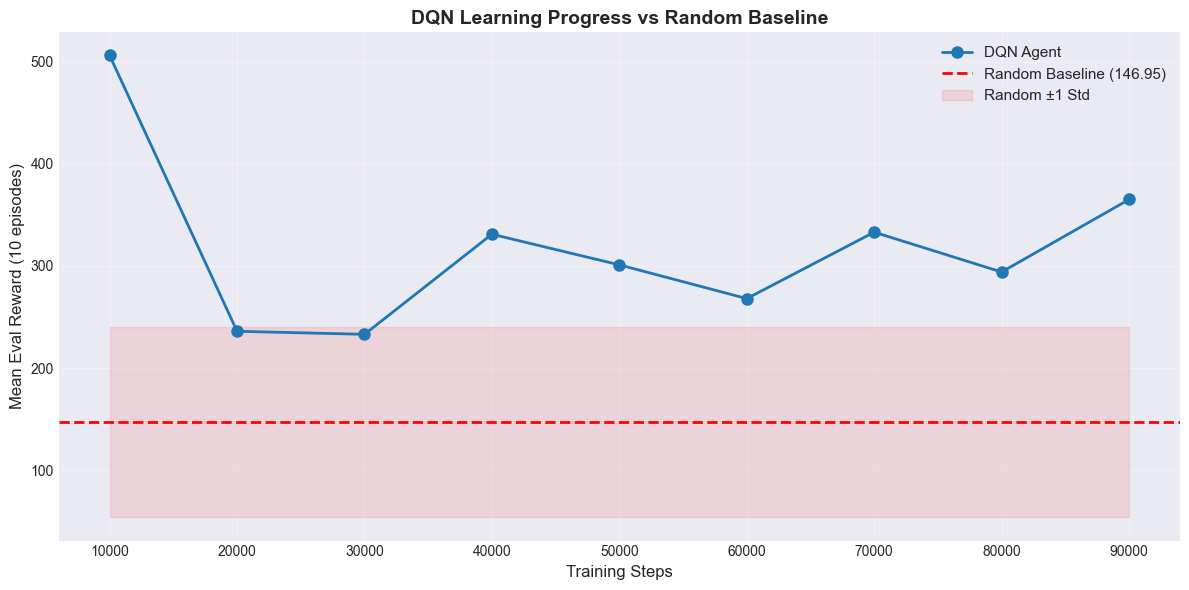


Improvement over baseline: +244.3%


In [22]:
# Plot evaluation rewards
fig, ax = plt.subplots(figsize=(12, 6))

eval_steps = np.array(metrics['eval_steps'])
eval_rewards = np.array(metrics['eval_rewards'])

ax.plot(eval_steps, eval_rewards, 'o-', linewidth=2, markersize=8, label='DQN Agent')
ax.axhline(146.95, color='red', linestyle='--', linewidth=2, label='Random Baseline (146.95)')
ax.fill_between(eval_steps, 146.95 - 93.14, 146.95 + 93.14, 
                color='red', alpha=0.1, label='Random ±1 Std')

ax.set_xlabel('Training Steps', fontsize=12)
ax.set_ylabel('Mean Eval Reward (10 episodes)', fontsize=12)
ax.set_title('DQN Learning Progress vs Random Baseline', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/phase4/learning_curve.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate improvement
if len(eval_rewards) > 0:
    improvement = ((metrics['max_eval_reward'] - 146.95) / 146.95) * 100
    print(f"\nImprovement over baseline: {improvement:+.1f}%")

## 3. Load and Test Trained Agent

In [23]:
# Create environment
env = make_atari_env('ALE/SpaceInvaders-v5', frame_stack=4, clip_rewards=False)

# Load trained agent
observation_shape = env.observation_space.shape
n_actions = env.action_space.n

agent = DQNAgent(
    observation_shape=observation_shape,
    n_actions=n_actions,
    device='cpu'
)

agent.load('../models/phase4/dqn_final.pt')
print("✓ Loaded trained DQN agent")

✓ Loaded trained DQN agent


In [24]:
# Test agent on 10 episodes
test_rewards = []

for episode in range(10):
    obs, _ = env.reset()
    episode_reward = 0
    done = False
    truncated = False
    
    while not (done or truncated):
        action = agent.select_action(obs, training=False)
        obs, reward, done, truncated, _ = env.step(action)
        episode_reward += reward
    
    test_rewards.append(episode_reward)
    print(f"Episode {episode+1}: {episode_reward}")

print(f"\nTest Performance:")
print(f"Mean: {np.mean(test_rewards):.2f} ± {np.std(test_rewards):.2f}")
print(f"Min: {np.min(test_rewards):.2f}")
print(f"Max: {np.max(test_rewards):.2f}")

Episode 1: 350.0
Episode 2: 515.0
Episode 3: 230.0
Episode 2: 515.0
Episode 3: 230.0
Episode 4: 480.0
Episode 5: 480.0
Episode 4: 480.0
Episode 5: 480.0
Episode 6: 360.0
Episode 7: 80.0
Episode 6: 360.0
Episode 7: 80.0
Episode 8: 325.0
Episode 9: 120.0
Episode 8: 325.0
Episode 9: 120.0
Episode 10: 245.0

Test Performance:
Mean: 318.50 ± 142.50
Min: 80.00
Max: 515.00
Episode 10: 245.0

Test Performance:
Mean: 318.50 ± 142.50
Min: 80.00
Max: 515.00


## 4. Visualize Agent Behavior

In [25]:
# Collect frames and actions from one episode
# Note: make_atari_env creates the environment internally, so just pass the ID
env_render = make_atari_env('ALE/SpaceInvaders-v5', frame_stack=4, clip_rewards=False)

obs, _ = env_render.reset()
frames = []
actions_taken = []
rewards_received = []
done = False
truncated = False

while not (done or truncated) and len(frames) < 200:  # Limit to 200 frames
    # Get frame before action
    frame = env_render.unwrapped.ale.getScreenRGB()
    frames.append(frame)
    
    # Select action
    action = agent.select_action(obs, training=False)
    actions_taken.append(action)
    
    # Take step
    obs, reward, done, truncated, _ = env_render.step(action)
    rewards_received.append(reward)

env_render.close()

print(f"Collected {len(frames)} frames")
print(f"Total reward: {sum(rewards_received)}")

Collected 200 frames
Total reward: 465.0


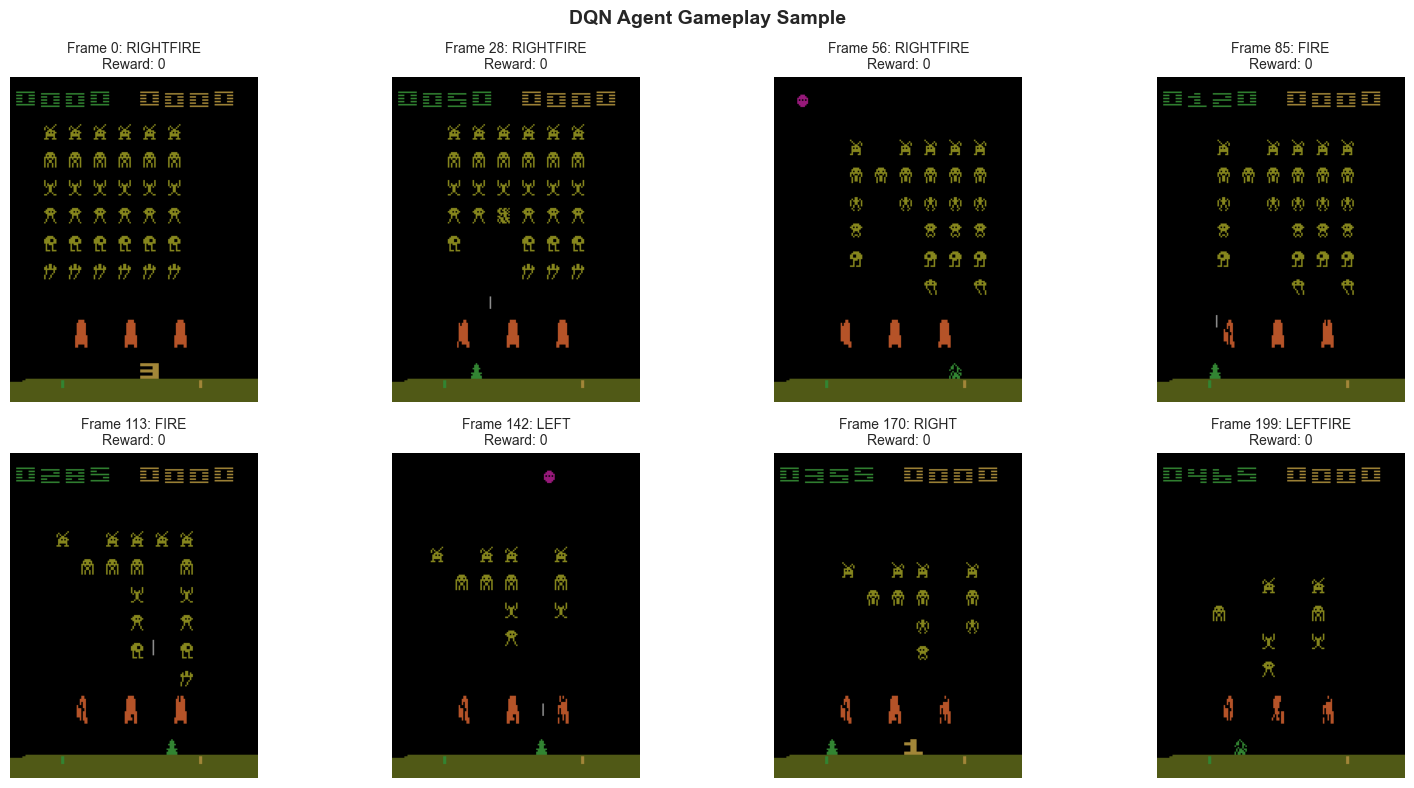

In [26]:
# Display sample frames
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Show frames at different points
frame_indices = np.linspace(0, len(frames)-1, 8, dtype=int)

action_names = [
    'NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE'
]

for i, idx in enumerate(frame_indices):
    axes[i].imshow(frames[idx])
    axes[i].axis('off')
    action_name = action_names[actions_taken[idx]] if actions_taken[idx] < len(action_names) else f'Action {actions_taken[idx]}'
    axes[i].set_title(f'Frame {idx}: {action_name}\nReward: {rewards_received[idx]:.0f}', 
                     fontsize=10)

plt.suptitle('DQN Agent Gameplay Sample', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/phase4/gameplay_sample.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Action Distribution Analysis

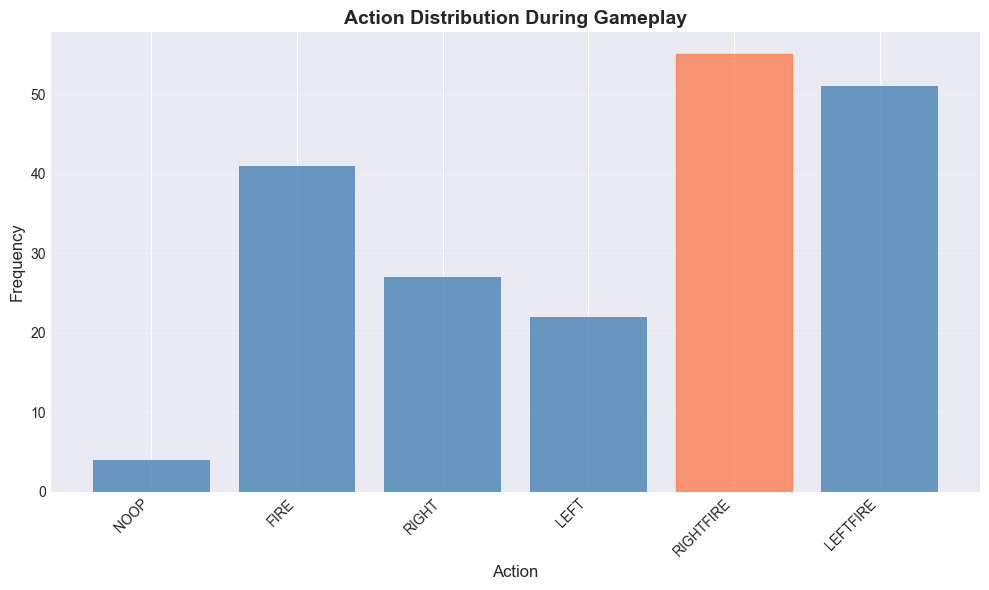


Action Distribution:
NOOP: 4 (2.0%)
FIRE: 41 (20.5%)
RIGHT: 27 (13.5%)
LEFT: 22 (11.0%)
RIGHTFIRE: 55 (27.5%)
LEFTFIRE: 51 (25.5%)


In [27]:
# Analyze action distribution
from collections import Counter

action_counts = Counter(actions_taken)
action_labels = [action_names[i] if i < len(action_names) else f'Action {i}' 
                for i in range(n_actions)]
action_frequencies = [action_counts.get(i, 0) for i in range(n_actions)]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(action_labels, action_frequencies, color='steelblue', alpha=0.8)

# Highlight most used action
max_idx = np.argmax(action_frequencies)
bars[max_idx].set_color('coral')

ax.set_xlabel('Action', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Action Distribution During Gameplay', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../outputs/phase4/action_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nAction Distribution:")
for label, count in zip(action_labels, action_frequencies):
    if count > 0:
        pct = (count / sum(action_frequencies)) * 100
        print(f"{label}: {count} ({pct:.1f}%)")

## 6. Comparison with Baseline

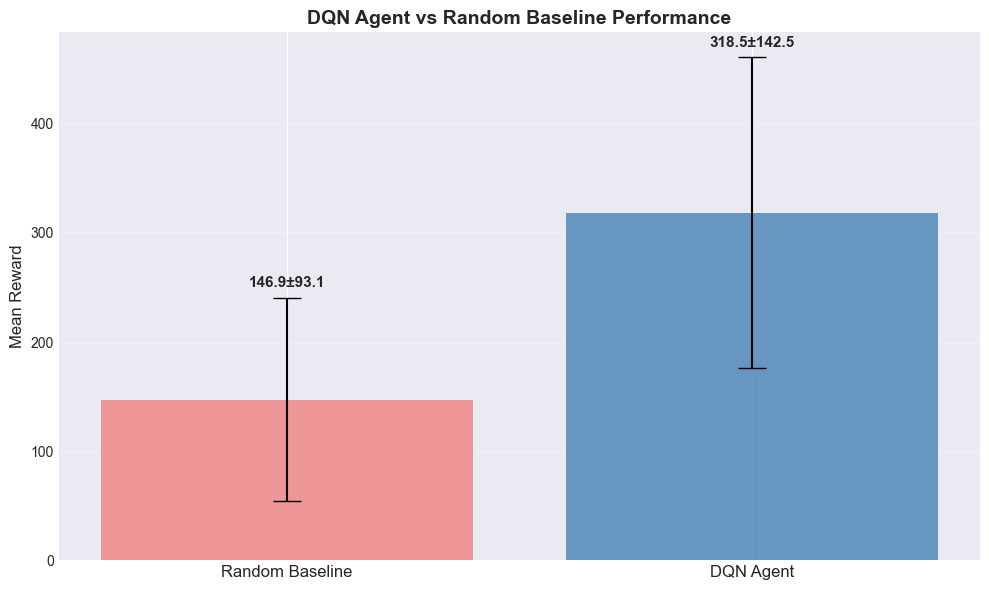


📈 Performance Improvement: +116.7%


In [28]:
# Load baseline data
with open('../data/phase2/baseline_statistics.json', 'r') as f:
    baseline = json.load(f)

# Compare performance
fig, ax = plt.subplots(figsize=(10, 6))

agents = ['Random Baseline', 'DQN Agent']
means = [baseline['reward_stats']['mean'], np.mean(test_rewards)]
stds = [baseline['reward_stats']['std'], np.std(test_rewards)]

x = np.arange(len(agents))
bars = ax.bar(x, means, yerr=stds, capsize=10, 
              color=['lightcoral', 'steelblue'], alpha=0.8)

ax.set_ylabel('Mean Reward', fontsize=12)
ax.set_title('DQN Agent vs Random Baseline Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(agents, fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (mean, std) in enumerate(zip(means, stds)):
    ax.text(i, mean + std + 10, f'{mean:.1f}±{std:.1f}', 
           ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/phase4/baseline_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

improvement = ((means[1] - means[0]) / means[0]) * 100
print(f"\n📈 Performance Improvement: {improvement:+.1f}%")

## 7. Summary and Next Steps

In [29]:
print("="*60)
print("PHASE 4 SUMMARY: DQN AGENT")
print("="*60)
print(f"\n✅ Trained DQN agent for 1M steps")
print(f"✅ Final performance: {means[1]:.1f} ± {stds[1]:.1f}")
print(f"✅ Baseline performance: {means[0]:.1f} ± {stds[0]:.1f}")
print(f"✅ Improvement: {improvement:+.1f}%")
print(f"\nKey Findings:")
print(f"  - DQN successfully learns from visual input")
print(f"  - Experience replay enables stable learning")
print(f"  - Target network prevents instability")
print(f"\n📊 Generated Outputs:")
print(f"  - Training curves and loss plots")
print(f"  - Gameplay visualizations")
print(f"  - Action distribution analysis")
print(f"  - Performance comparison")
print(f"\n🎯 Next Phase: DQN Improvements")
print(f"  - Double DQN (reduce overestimation)")
print(f"  - Dueling Networks (separate V and A)")
print(f"  - Prioritized Experience Replay")
print("="*60)

PHASE 4 SUMMARY: DQN AGENT

✅ Trained DQN agent for 1M steps
✅ Final performance: 318.5 ± 142.5
✅ Baseline performance: 146.9 ± 93.1
✅ Improvement: +116.7%

Key Findings:
  - DQN successfully learns from visual input
  - Experience replay enables stable learning
  - Target network prevents instability

📊 Generated Outputs:
  - Training curves and loss plots
  - Gameplay visualizations
  - Action distribution analysis
  - Performance comparison

🎯 Next Phase: DQN Improvements
  - Double DQN (reduce overestimation)
  - Dueling Networks (separate V and A)
  - Prioritized Experience Replay
